In [112]:
using Pkg
Pkg.activate("/home/fedflorio/master_thesis")

  Activating project at `~/master_thesis`


In [113]:
using MatrixProductBP, MatrixProductBP.Models
using TensorTrains, LogarithmicNumbers
using Graphs, IndexedGraphs, SparseArrays
using Random, Statistics
using Plots, LaTeXStrings
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

In [114]:
using Revise
includet("/home/fedflorio/master_thesis/MatrixProductBP.jl/notebooks/glauber_continuous/BAMPS.jl")

In [115]:
T = 7
N = 5
k = 2
maxJ = 5
K = 2*maxJ + 1
seed = 0
separation = 2
nsnaps = 3

rng = MersenneTwister(seed)
A = [0 1 1 0 1;
     1 0 0 1 0;
     1 0 0 1 0;
     0 1 1 0 1;
     1 0 0 1 0]
A = sparse(A)
# gg = random_regular_graph(N, k; seed)
# gg = prufer_decode(rand(rng, 1:N, N-2))
# gg = path_graph(N)

# A = adjacency_matrix(gg)
rand!(rng, A.nzval, (-maxJ:maxJ))  # fill directed incidence matrix with rand(-1,1)
g = IndexedBiDiGraph(A)
β = 0.2
h = 0.5

w = [fill(MatrixProductBP.Models.IntegerGlauberFactor([A[j,i] for j in inneighbors(g,i)], h, β), T+1) for i in vertices(g)]
# w = [fill(GenericGlauberFactor([A[j,i] for j in inneighbors(g,i)]*J, h, β), T+1) for i in vertices(g)]
bp = mpbp(g, w, fill(2,N), T);

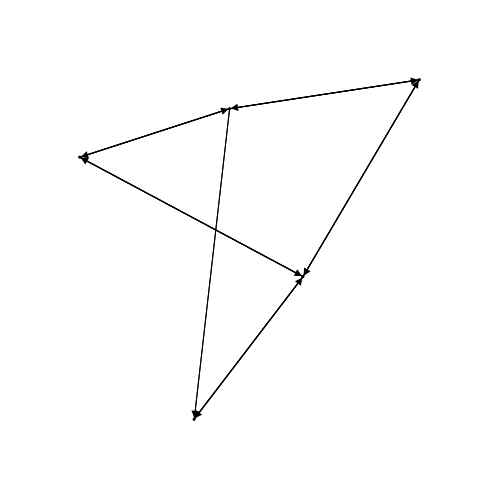

In [116]:
using GraphRecipes
graphplot(SimpleDiGraph(A), curves=false, size=(500,500), nodeshape=:circle,
    nodecolor=:black, nodesize=0.01, arrow=arrow(:closed, 0.1))

In [117]:
obs_times = collect(range(separation, step=separation, length=nsnaps))
nobs = floor(Int, N * length(obs_times) * 1.0)
obs_fraction = nobs / N
rng = MersenneTwister(seed)
X, observed = draw_node_observations!(bp, nobs, times = obs_times .+ 1, softinf=Inf; rng);

In [118]:
reset!(bp)
# spin(x, i) = 3-2x
# spin(x) = spin(x, 0)
cb = CB_BP(bp);

In [119]:
svd_trunc = TruncBond(4)
iters, cb = iterate!(bp, maxiter=50; svd_trunc, cb, tol=1e-4, damp=0.2);

Running MPBP: iter 12    Time: 0:00:03
  Δ:                7.978937817165743e-5


In [120]:
b = bp.b[1]
bBasis = BAMPS(b,4)

BasisTensorTrain{Float64, 2}([[[-0.8074591310877897 0.9492227658898378], [-0.7066108425761528 -0.1605011610391483 -0.9365813450648669 -0.38829111011712736; 0.647763731145976 -0.9244848419375827 -0.11682335282572104 -0.5148750698321352], [-0.8119982078493431 0.32776057852874774 … 0.0 0.0; 0.3214617489756521 0.6439494129802624 … 0.0 0.0; 0.11703710152168544 0.5042888875122518 … 0.0 -0.8811963764282629; -0.011429133504916138 -0.010095961907209306 … 0.8811963764282629 0.0], [-0.8818677520877564 -0.744781058384589 … 2.3172790958278435e-10 6.587286425428223e-9; 0.039006062420736495 -0.4426928394531501 … 1.3598913603164018e-9 3.8971804400506635e-8; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.8777453360161609 -0.02223781151863836 … -0.0007774959820775066 -5.754892742270939e-6; -0.07479953596476767 -0.4766053732096659 … -0.013364197723891212 0.00019396837158734071; … ; -1.0556310977228692e-12 1.5755531343818755e-12 … 1.4082560789523546e-9 -1.3833133959936152e-8; -1.9732934053715167e-13 -1.100

In [121]:
b_reconstruct = reconstruct_BAMPS(bBasis)

TensorTrain{Float64, 3}([[-3.5133637939552544 0.28352726960409624;;; 0.28352726960409624 3.513363793955255], [-0.20393535842188193 1.3187375638790155 -2.5392959352684654 -2.048275035636973; 0.2591413982753119 -1.8092436927103817 1.2512754079988042 -2.741879959208619;;; -2.6225080118827293 -1.9607422080356085 -1.2070294449910022 0.4951105951684638; 2.331913526308592 -1.8886956750399493 -1.7185688193016881 0.6823796798800785], [-3.2479928313973723 1.311042314114991 … 0.0 0.0; 1.2858469959026084 2.5757976519210497 … 0.0 0.0; 0.46814840608674174 2.017155550049007 … 0.0 0.0; -0.04571653401966455 -0.040383847628837226 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 -3.5247855057130515; 0.0 0.0 … 3.5247855057130515 0.0], [-3.5186808801254847 -0.11288571542647308 … 3.5128327904554336e-9 3.6009809078592374e-10; 0.20200265816133797 -2.031723471499979 … 2.073758166721734e-8 2.1255572568067938e-9; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; -0.008790128225540705 -2.866238518111883

In [122]:
marg_bp = marginals(b)
display(marg_bp)
p_bp = [bᵗ[1] for bᵗ in marg_bp]

marg_Basis = marginals(b_reconstruct)
display(marg_Basis)
p_Basis = [bᵗ[1] for bᵗ in marg_Basis]
;

8-element Vector{Vector{Float64}}:
 [0.4629536142655335, 0.5370463857344666]
 [0.1792950601130279, 0.8207049398869722]
 [1.0, 4.180847061324406e-18]
 [0.9516538796995835, 0.04834612030041651]
 [1.3834796953118829e-16, 0.9999999999999999]
 [0.010618831603757092, 0.9893811683962429]
 [-1.6606536923884226e-17, 1.0]
 [0.7310585788640068, 0.26894142113599306]

8-element Vector{Vector{Float64}}:
 [0.4629536142655334, 0.5370463857344666]
 [0.1792950601130279, 0.820704939886972]
 [1.0, 4.180853582087112e-18]
 [0.9516538796995834, 0.04834612030041654]
 [1.2576378825814718e-16, 0.9999999999999999]
 [0.010618831603757102, 0.9893811683962429]
 [-7.392859883731124e-18, 1.0]
 [0.7310585788640068, 0.26894142113599306]

In [123]:
t=3
display(b[t])
display(b_reconstruct[t])
println("\n\n")
for α in eachindex(bBasis)
    display(bBasis[α][t])
end
;

4×8×2 Array{Float64, 3}:
[:, :, 1] =
 -0.811998    0.327761  -0.0943166  -0.0290405  …  -1.97873e-18  0.0  0.0
  0.321462    0.643949  -0.497548   -0.104616      -7.12824e-18  0.0  0.0
  0.117037    0.504289   0.692622    0.169639       1.15587e-17  0.0  0.0
 -0.0114291  -0.010096  -0.20083     0.857871       5.84527e-17  0.0  0.0

[:, :, 2] =
 0.0  0.0  7.48958e-16  -5.97e-12  …   2.59967e-11  0.0        0.0
 0.0  0.0  0.0           0.0          -0.881196     0.0        0.0
 0.0  0.0  0.0           0.0           0.0          0.0       -0.881196
 0.0  0.0  0.0           0.0           0.0          0.881196   0.0

4×8×2 Array{Float64, 3}:
[:, :, 1] =
 -3.24799     1.31104    -0.377266  -0.116162  …  -7.91493e-18  0.0  0.0
  1.28585     2.5758     -1.99019   -0.418465      0.0          0.0  0.0
  0.468148    2.01716     2.77049    0.678555      4.62347e-17  0.0  0.0
 -0.0457165  -0.0403838  -0.80332    3.43148       2.33811e-16  0.0  0.0

[:, :, 2] =
 0.0  0.0  2.9976e-15  -2.388e-11  …   1.03987e-10  0.0       0.0
 0.0  0.0  0.0          0.0           -3.52479      0.0       0.0
 0.0  0.0  0.0          0.0            0.0          0.0      -3.52479
 0.0  0.0  0.0          0.0            0.0          3.52479   0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …   2.59967e-11  0.0        0.0
  0.321462    0.643949  -0.497548      -0.881196     0.0        0.0
  0.117037    0.504289   0.692622       1.15587e-17  0.0       -0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  0.881196   0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …  -2.59967e-11   0.0       0.0
  0.321462    0.643949  -0.497548       0.881196      0.0       0.0
  0.117037    0.504289   0.692622       1.15587e-17   0.0       0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  -0.881196  0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …   2.59967e-11  0.0        0.0
  0.321462    0.643949  -0.497548      -0.881196     0.0        0.0
  0.117037    0.504289   0.692622       1.15587e-17  0.0       -0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  0.881196   0.0

4×8 Matrix{Float64}:
 -0.811998    0.327761  -0.0943166  …  -2.59967e-11   0.0       0.0
  0.321462    0.643949  -0.497548       0.881196      0.0       0.0
  0.117037    0.504289   0.692622       1.15587e-17   0.0       0.881196
 -0.0114291  -0.010096  -0.20083        5.84527e-17  -0.881196  0.0